In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import os

import matplotlib.pyplot as plt
from tqdm import tqdm
import GridWorld_v5
import draw

import utils

In [2]:
class AdvantageActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, env_row, env_column, learning_rate_critic,learning_rate_actor, gamma):
        self.action_dim = action_dim
        self.state_dim =state_dim

        self.env_row = env_row
        self.env_column = env_column
        
        self.policy_tabular = np.full((env_row * env_column, action_dim), 1/action_dim)
        self.state_values = np.random.random(env_row * env_column)
        
        self.learning_rate_actor = learning_rate_actor
        self.learning_rate_critic = learning_rate_critic
        
        
        self.gamma = gamma  # 折扣因子
        self.epsilon = 1

    def take_action(self, state):  # 根据动作概率分布随机采样 #state都是（x，y）的
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_dim)
        else:
            x, y = state[0], state[1]
            now_frame_probabilities  = self.policy_tabular[x *self.env_column + y]
            action = None
            try:
                action = np.random.choice(self.action_dim, p=now_frame_probabilities)
            except:
                action = np.random.choice(self.action_dim)
            return action
            
    def softmax(self, logits):
        exps = np.exp(logits - np.max(logits))  # 为了数值稳定性，从每个logit中减去最大值
        return exps / np.sum(exps)
        
    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        next_state_list = transition_dict['next_states']
        action_list = transition_dict['actions']
        dones_list = transition_dict['dones']
        losses = [[[]for j in range(self.action_dim)] for i in range(self.env_column * self.env_row)]
                
        for i in reversed(range(len(reward_list))):  # 从最后一步算起
            # unzip data
            x,y = state_list[i][0], state_list[i][1]
            nx,ny = next_state_list[i][0], next_state_list[i][1]
            tmpstate, tmpaction, tmpscore, nextState, terminal = x*self.env_column+y ,action_list[i], reward_list[i], nx*self.env_column + ny, dones_list[i] 
            
            # Critic update
            next_state_value = self.state_values[nextState]
            target = tmpscore + (1.0 - terminal) * self.gamma * next_state_value
            TD_error = target - self.state_values[tmpstate]
            self.state_values[tmpstate] += self.learning_rate_critic * TD_error

            losses[tmpstate][tmpaction].append(TD_error)
            
            # Actor update
            grad = 1 / self.policy_tabular[tmpstate][tmpaction]
            self.policy_tabular[tmpstate][tmpaction] += self.learning_rate_actor * grad * TD_error
            #重新规范化，把概率总和变成0~1
            # self.policy_tabular = np.maximum(self.policy_tabular, 0) #把小于0的概率规范化成0
            self.policy_tabular = np.clip(self.policy_tabular, 0.001, 1) #把小于0的概率规范化成0
            self.policy_tabular = self.policy_tabular/self.policy_tabular.sum(axis=1)[:,None]
            self.policy_tabular = np.nan_to_num(self.policy_tabular, nan=1 / self.action_dim)
            
        loss_mean = np.array([[sum(losses[i][j]) / len(losses[i][j] ) if len(losses[i][j])!=0 else 0 for j in range(self.action_dim)] for i in range(self.env_column * self.env_row)])
        loss_sum = np.array([[sum(losses[i][j]) if len(losses[i][j])!=0 else 0 for j in range(self.action_dim)] for i in range(self.env_column * self.env_row)])
        loss = loss_mean
        self.loss = loss

In [3]:
def train(hyperparameters, img_path):
    rows = 5      #记得行数和列数这里要同步改
    columns = 5
    
    forbiddenAreaScore = hyperparameters['forbiddenAreaScore']
    targetAreaScore = hyperparameters['targetAreaScore']
    hitWallScore = hyperparameters['hitWallScore']
    moveScore = hyperparameters['moveScore']
    start_state = hyperparameters['start_state']
    action_space = hyperparameters['action_space']
    learning_rate_critic = hyperparameters['learning_rate_critic']
    learning_rate_actor = hyperparameters['learning_rate_actor']
    num_episodes = hyperparameters['num_episodes']
    hidden_dim = hyperparameters['hidden_dim']
    gamma = hyperparameters['gamma']
    
    env = GridWorld_v5.GridWorld_v5(initState=start_state, moveScore=moveScore, action_space=action_space, forbiddenAreaScore=forbiddenAreaScore, score=targetAreaScore, hitWallScore = hitWallScore,
                                    desc = [".....",".##..","..#..",".#T#.",".#..."]) 
    
    # env = GridWorld_v5.GridWorld_v5(initState=start_state, moveScore=moveScore, action_space=action_space, forbiddenAreaScore=forbiddenAreaScore, score=targetAreaScore, hitWallScore = hitWallScore,
    #                                 desc = ["...#..T",
    #                                         ".....#."]) 
    
    # env = GridWorld_v5.GridWorld_v5(initState=start_state, moveScore=moveScore, action_space=action_space, forbiddenAreaScore=forbiddenAreaScore, score=targetAreaScore, hitWallScore = hitWallScore,
    #                                 desc = ["...#...",
    #                                         ".....#T"]) 
    
    agent = AdvantageActorCritic(state_dim = env.get_observation_space(), 
              hidden_dim = hidden_dim, 
              action_dim = env.get_action_space(), 
              env_row = env.rows, 
              env_column = env.columns, 
              learning_rate_actor = learning_rate_actor, 
              learning_rate_critic = learning_rate_critic,
              gamma = gamma)
    print(agent)
    return_list = []

    epsilon = 0.15
    final_epsilon = 0.01
    pbar = tqdm(range(num_episodes))
    for i in pbar:# 10000
        if(epsilon > final_epsilon) :
            epsilon -= hyperparameters['gamma_minus_each_episodes']
        else:
            epsilon = final_epsilon
        agent.epsilon = epsilon

        episode_return = 0
        transition_dict = {
            'states': [],
            'actions': [],
            'next_states': [],
            'rewards': [],
            'dones': []
        }
        state = env.reset()
        done = False
        cnt = 0
        while not done:
            cnt = cnt + 1
            action = agent.take_action(state) ########
            next_state, reward, done, _ = env.step(action)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            state = next_state
            episode_return += reward

            # if episode_return <= forbiddenAreaScore*2:
            #     break  #如果被惩罚了两次，那么就跳出迭代，开始扣分！！

            if cnt>hyperparameters['exploring_step']:
                break
            
        return_list.append(episode_return)
        pre_frame_probabilities = agent.policy_tabular.copy()

        agent.update(transition_dict)

        now_frame_probabilities = agent.policy_tabular
        pbar.set_postfix({"epsilon": epsilon})
        if i % 300 == 0:
            state_values = agent.state_values
            p = np.argmax(agent.policy_tabular,axis=1)
            draw.draw(state_values.reshape(5,5), p)
            draw.plot_policy(pre_frame_probabilities, now_frame_probabilities, agent.loss , transition_dict['states'], env.get_map_description(), img_path)

experiments/Penalty-100_Score50_State(0~24)/Penalty-100_Score50_State10


  0%|                                                                                                                                         | 0/2100 [00:00<?, ?it/s, epsilon=0.15]

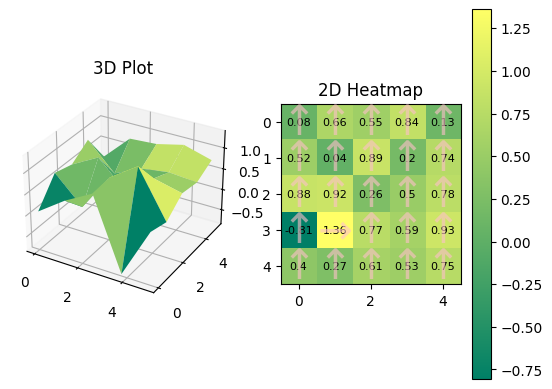

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


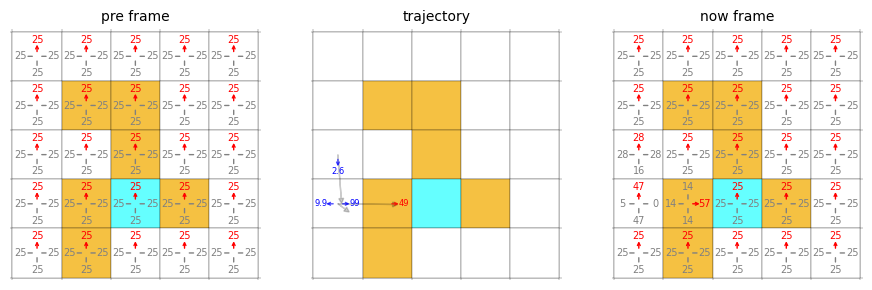

 14%|█████████████████                                                                                                            | 287/2100 [00:04<00:07, 231.74it/s, epsilon=0.147]

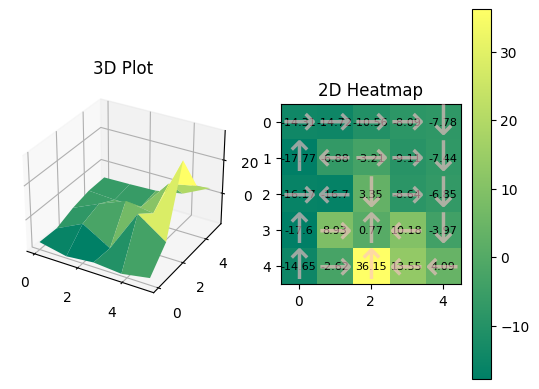

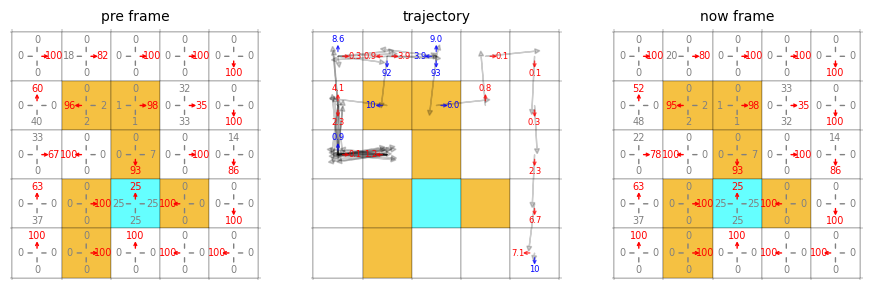

 28%|██████████████████████████████████▍                                                                                          | 579/2100 [00:08<00:07, 207.51it/s, epsilon=0.144]

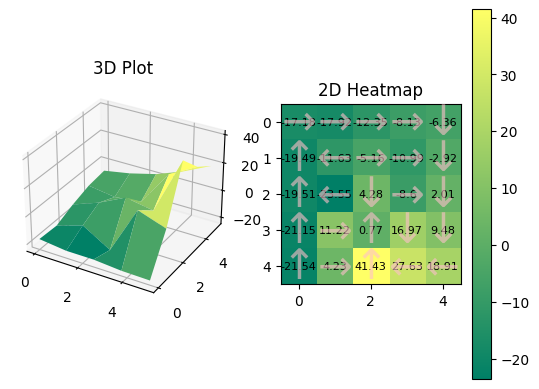

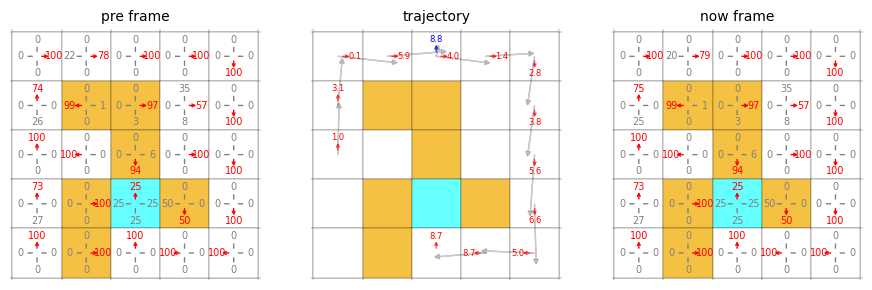

 42%|███████████████████████████████████████████████████▉                                                                         | 873/2100 [00:13<00:06, 182.92it/s, epsilon=0.141]

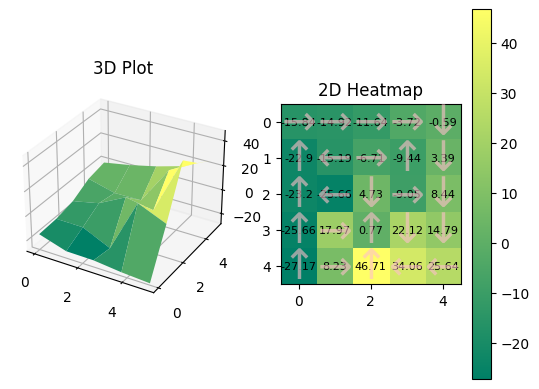

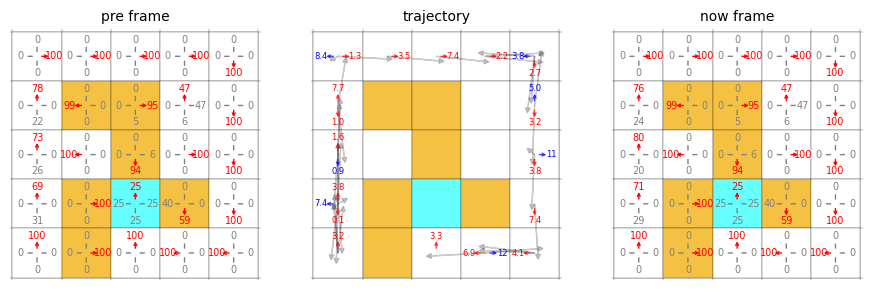

 56%|██████████████████████████████████████████████████████████████████████                                                      | 1186/2100 [00:17<00:03, 229.08it/s, epsilon=0.138]

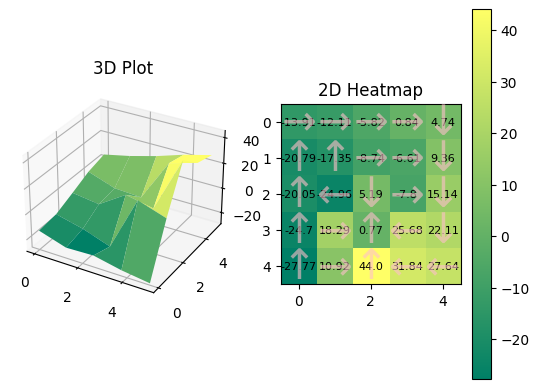

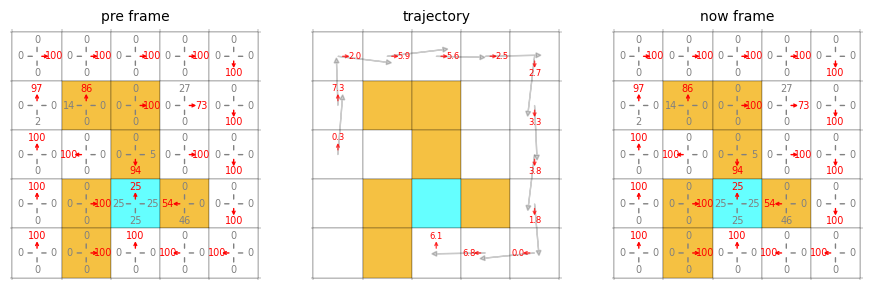

 71%|███████████████████████████████████████████████████████████████████████████████████████▍                                    | 1481/2100 [00:21<00:02, 210.83it/s, epsilon=0.135]

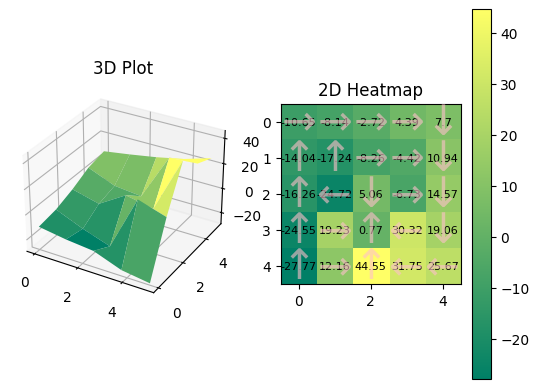

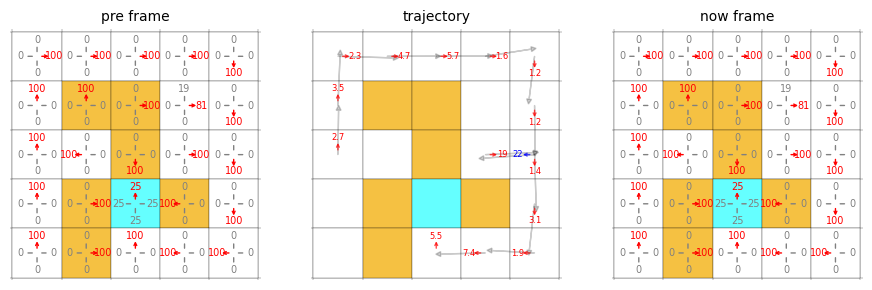

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1777/2100 [00:25<00:01, 208.69it/s, epsilon=0.132]

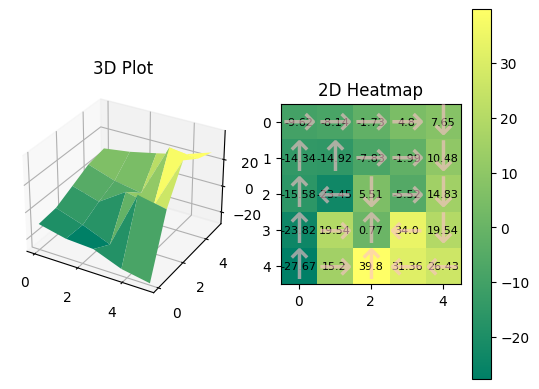

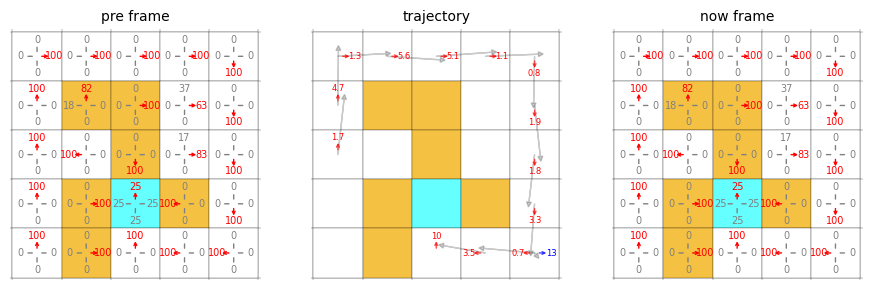

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2100/2100 [00:29<00:00, 70.49it/s, epsilon=0.129]


The file experiments/Penalty-100_Score50_State(0~24)/Penalty-100_Score50_State.xlsx does not exist. Creating a new workbook.


In [4]:
hyperparameters = {
    'forbiddenAreaScore': -100,  #踩陷阱和碰壁的惩罚
    'hitWallScore': -10,
    'targetAreaScore': 50,     #奖励
    'moveScore': -1,            #移动惩罚
    'action_space': 4,         
    'learning_rate_critic': 0.01,    
    'learning_rate_actor': 0.01,    
    'hidden_dim': 512,
    'gamma': 0.9,              #折扣因子
    'num_episodes': 2100,      #训练轮次，每次训练epsilon -= gamma_minus_each_episodes
    'start_state': 10,
    'gamma_minus_each_episodes':0.00001,
    'exploring_step':50
}

start_state = hyperparameters['start_state']

# 创建 images 文件夹（如果不存在）
experiment_name = f"Penalty{hyperparameters['forbiddenAreaScore']}_Score{hyperparameters['targetAreaScore']}_State"
output_dir = f"experiments/{experiment_name}(0~24)/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# 图片文件路径

img_name = f"{experiment_name}{start_state}"
img_path = os.path.join(output_dir, img_name)
xlsx_path = os.path.join(output_dir, experiment_name+".xlsx")
print(img_path)
train(hyperparameters, img_path)

utils.write_excel(hyperparameters ,img_path+'.png', bias = start_state, xlsx_path=xlsx_path, highlights=['start_state'])
